## Google Drive のマウント
Colab で実行する場合、以下のセルを実行して Google Drive をマウントし、データファイルにアクセスできるようにしてください。ローカル環境の場合はスキップして構いません。

In [161]:
"""
# Google Drive を Colab にマウント
# Colab でのみ必要。ローカル環境や他のプラットフォームでは実行しないでください。
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    # 例: 作業ディレクトリを提出フォルダとしてMyDrive直下にコピーした場合、下記により作業ディレクトリを移動
    %cd /content/drive/MyDrive/提出フォルダ
except ModuleNotFoundError:
    print("google.colab ランタイムではないため、Drive マウントをスキップします。")
"""


'\n# Google Drive を Colab にマウント\n# Colab でのみ必要。ローカル環境や他のプラットフォームでは実行しないでください。\ntry:\n    from google.colab import drive  # type: ignore\n    drive.mount(\'/content/drive\')\n    # 例: 作業ディレクトリを提出フォルダとしてMyDrive直下にコピーした場合、下記により作業ディレクトリを移動\n    %cd /content/drive/MyDrive/提出フォルダ\nexcept ModuleNotFoundError:\n    print("google.colab ランタイムではないため、Drive マウントをスキップします。")\n'

# 表情推定による笑顔検出

このノートブックでは、**`smile_predict`** 関数の実装および評価を行います。  
以下のセルをベースに、自由に追加セルを作成して実験・検証を行ってください。

---

### TODO
- `smile_predict` を実装して笑顔判定ロジックを完成させる  
- 評価セルを実行し **Train / Test accuracy** を確認する

※注意：実行はこのipynbファイルだけで完結する形にしてください。



In [162]:
# ============================================================================
# Phase 1: 探索的アプローチ - データ読み込みと基本統計
# ============================================================================
import json
from pathlib import Path
import numpy as np

# データセットのロード
data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as fp:
    data = json.load(fp)

train = data['train']
test = data['test']

# データの基本情報を表示
print("="*60)
print("=== データセットの基本情報 ===")
print("="*60)
print(f"Trainデータ数: {len(train)}")
print(f"Testデータ数: {len(test)}")

# Trainデータ内の笑顔/非笑顔の分布を確認
train_smile_count = sum(1 for sample in train if sample[-1]['smile'])
train_non_smile_count = len(train) - train_smile_count

print(f"\nTrainデータ内の分布:")
print(f"  笑顔: {train_smile_count} ({train_smile_count/len(train)*100:.1f}%)")
print(f"  非笑顔: {train_non_smile_count} ({train_non_smile_count/len(train)*100:.1f}%)")

# 特徴点の数を確認（各サンプルは15個の特徴点を持つ）
print(f"\n特徴点数: {len(train[0]) - 2}")  # IDとラベルを除いた数
print("="*60)

=== データセットの基本情報 ===
Trainデータ数: 657
Testデータ数: 282

Trainデータ内の分布:
  笑顔: 302 (46.0%)
  非笑顔: 355 (54.0%)

特徴点数: 15


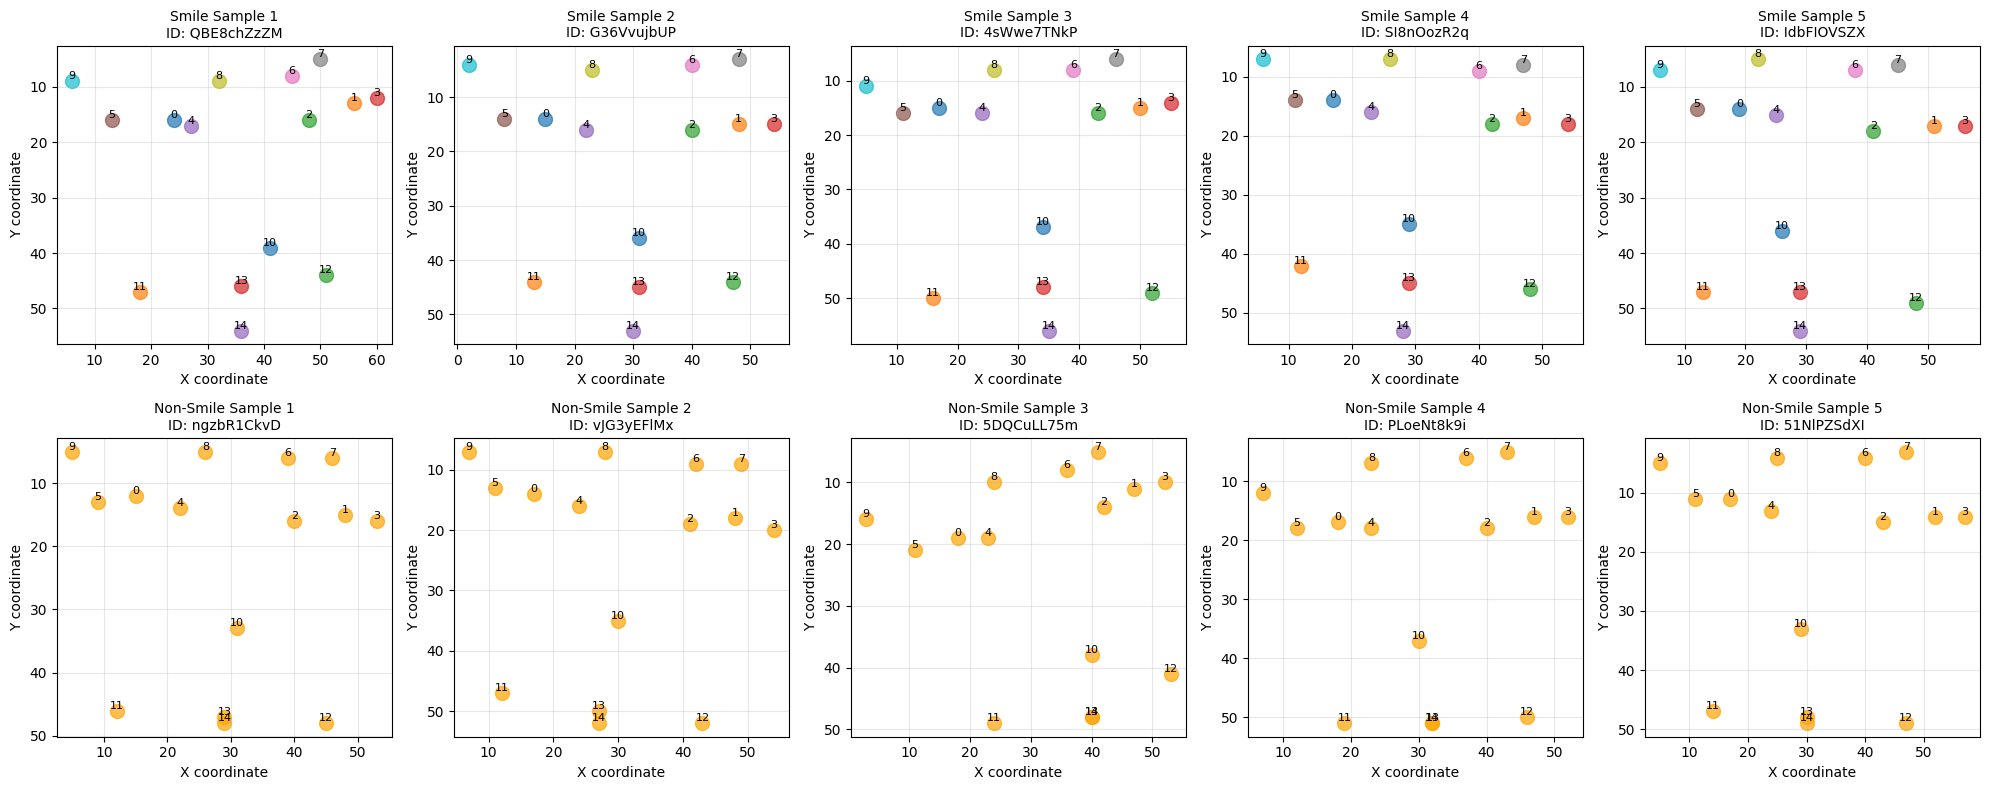


上段: 笑顔サンプル 5個
下段: 非笑顔サンプル 5個
各数字は特徴点のインデックス（0-14）を示しています


In [163]:
# ============================================================================
# Phase 1: 探索的アプローチ - データ可視化（特徴点の配置パターン）
# ============================================================================
import matplotlib.pyplot as plt

# 笑顔サンプルと非笑顔サンプルを分離
smile_samples = [s for s in train if s[-1]['smile']]
non_smile_samples = [s for s in train if not s[-1]['smile']]

# サンプル数を制限して可視化（多すぎると見づらいため）
num_samples_to_plot = min(5, len(smile_samples), len(non_smile_samples))

# 笑顔サンプルの可視化
fig, axes = plt.subplots(2, num_samples_to_plot, figsize=(4*num_samples_to_plot, 8))
if num_samples_to_plot == 1:
    axes = axes.reshape(-1, 1)

# 笑顔サンプルをプロット
for idx in range(num_samples_to_plot):
    sample = smile_samples[idx]
    keypoints = sample[1:-1]  # IDとラベルを除いた15個の座標
    
    ax = axes[0, idx]
    # 各特徴点をプロット
    for i, (x, y) in enumerate(keypoints):
        ax.scatter(x, y, s=100, alpha=0.7)
        ax.text(x, y, str(i), fontsize=8, ha='center', va='bottom')
    
    ax.set_title(f'Smile Sample {idx+1}\nID: {sample[0]}', fontsize=10)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.invert_yaxis()  # 画像座標系に合わせる（上方向が負）
    ax.grid(True, alpha=0.3)

# 非笑顔サンプルをプロット
for idx in range(num_samples_to_plot):
    sample = non_smile_samples[idx]
    keypoints = sample[1:-1]  # IDとラベルを除いた15個の座標
    
    ax = axes[1, idx]
    # 各特徴点をプロット
    for i, (x, y) in enumerate(keypoints):
        ax.scatter(x, y, s=100, alpha=0.7, color='orange')
        ax.text(x, y, str(i), fontsize=8, ha='center', va='bottom')
    
    ax.set_title(f'Non-Smile Sample {idx+1}\nID: {sample[0]}', fontsize=10)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.invert_yaxis()  # 画像座標系に合わせる
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n上段: 笑顔サンプル {num_samples_to_plot}個")
print(f"下段: 非笑顔サンプル {num_samples_to_plot}個")
print("各数字は特徴点のインデックス（0-14）を示しています")

In [164]:
# ============================================================================
# Phase 1: 探索的アプローチ - 統計分析（笑顔/非笑顔での特徴点の違い）
# ============================================================================
import numpy as np

# 各特徴点の座標を笑顔/非笑顔で分けて集計
num_keypoints = 15
smile_keypoints_x = [[] for _ in range(num_keypoints)]
smile_keypoints_y = [[] for _ in range(num_keypoints)]
non_smile_keypoints_x = [[] for _ in range(num_keypoints)]
non_smile_keypoints_y = [[] for _ in range(num_keypoints)]

# Trainデータから座標を抽出
for sample in train:
    keypoints = sample[1:-1]  # IDとラベルを除いた15個の座標
    is_smile = sample[-1]['smile']
    
    for i, (x, y) in enumerate(keypoints):
        if is_smile:
            smile_keypoints_x[i].append(x)
            smile_keypoints_y[i].append(y)
        else:
            non_smile_keypoints_x[i].append(x)
            non_smile_keypoints_y[i].append(y)

# 各特徴点の平均位置と標準偏差を計算
print("="*100)
print("=== 各特徴点の統計情報（笑顔 vs 非笑顔） ===")
print("="*100)
print(f"{'Point':<6} {'Smile Avg (X,Y)':<25} {'Non-Smile Avg (X,Y)':<25} {'X Diff':<12} {'Y Diff':<12}")
print("-"*100)

# X座標とY座標の両方の差を計算
x_differences = []
y_differences = []

for i in range(num_keypoints):
    smile_avg_x = np.mean(smile_keypoints_x[i])
    smile_avg_y = np.mean(smile_keypoints_y[i])
    non_smile_avg_x = np.mean(non_smile_keypoints_x[i])
    non_smile_avg_y = np.mean(non_smile_keypoints_y[i])
    
    # X座標とY座標の差を計算
    x_diff = smile_avg_x - non_smile_avg_x
    y_diff = smile_avg_y - non_smile_avg_y
    
    x_differences.append((i, x_diff, abs(x_diff)))
    y_differences.append((i, y_diff, abs(y_diff)))
    
    # 座標を文字列としてフォーマットして列幅を固定
    smile_coord_str = f"({smile_avg_x:>6.2f}, {smile_avg_y:>6.2f})"
    non_smile_coord_str = f"({non_smile_avg_x:>6.2f}, {non_smile_avg_y:>6.2f})"
    print(f"{i:<6} {smile_coord_str:<25} {non_smile_coord_str:<25} {x_diff:>12.2f} {y_diff:>12.2f}")

# X座標とY座標の差を比較
print("\n" + "="*100)
print("=== X座標の差が大きい特徴点 Top 5 ===")
print("="*100)
x_differences.sort(key=lambda x: x[2], reverse=True)
for rank, (point_idx, x_diff, abs_diff) in enumerate(x_differences[:5], 1):
    direction = "右に移動" if x_diff > 0 else "左に移動"
    print(f"{rank}. 特徴点 {point_idx}: 差 {abs_diff:.2f} ({direction})")

print("\n" + "="*100)
print("=== Y座標の差が大きい特徴点 Top 5（笑顔で位置が変わりやすい点） ===")
print("="*100)
y_differences.sort(key=lambda x: x[2], reverse=True)
for rank, (point_idx, y_diff, abs_diff) in enumerate(y_differences[:5], 1):
    direction = "上に移動" if y_diff < 0 else "下に移動"
    print(f"{rank}. 特徴点 {point_idx}: 差 {abs_diff:.2f} ({direction})")

print("\n" + "="*100)
print("=== 分析結果の解釈 ===")
print("="*100)
print("・Y座標の差が大きい特徴点: 笑顔で垂直方向に大きく移動（口角、頬など）")
print("・X座標の差が大きい特徴点: 笑顔で水平方向に大きく移動（口の幅など）")
print("・両方の差を確認することで、より正確な特徴点の意味づけが可能")
print("="*100)

=== 各特徴点の統計情報（笑顔 vs 非笑顔） ===
Point  Smile Avg (X,Y)           Non-Smile Avg (X,Y)       X Diff       Y Diff      
----------------------------------------------------------------------------------------------------
0      ( 16.15,  15.12)          ( 15.97,  15.12)                  0.19        -0.00
1      ( 47.74,  14.82)          ( 46.99,  14.54)                  0.75         0.28
2      ( 40.77,  16.14)          ( 40.12,  15.84)                  0.66         0.30
3      ( 53.34,  15.13)          ( 52.63,  14.83)                  0.70         0.30
4      ( 22.92,  16.25)          ( 22.75,  16.10)                  0.17         0.14
5      ( 10.20,  15.51)          ( 10.22,  15.63)                 -0.02        -0.12
6      ( 38.98,   6.05)          ( 38.41,   5.88)                  0.58         0.17
7      ( 45.57,   4.96)          ( 44.90,   4.91)                  0.67         0.04
8      ( 24.77,   6.32)          ( 24.38,   6.15)                  0.39         0.17
9      (  4.77,   8.

In [165]:
# ============================================================================
# Phase 1: 探索的アプローチ - 特徴点間の距離分析
# ============================================================================
import numpy as np

def calculate_distance(p1, p2):
    """2点間のユークリッド距離を計算"""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# 全ての特徴点ペア間の距離を計算
num_keypoints = 15
distance_differences = []

print("="*80)
print("=== 特徴点間の距離分析（笑顔 vs 非笑顔） ===")
print("="*80)
print("笑顔/非笑顔で距離が大きく変わる特徴点ペアを特定します...\n")

# 全ての特徴点ペアについて距離の差を計算
for i in range(num_keypoints):
    for j in range(i + 1, num_keypoints):
        smile_distances = []
        non_smile_distances = []
        
        for sample in train:
            keypoints = sample[1:-1]
            is_smile = sample[-1]['smile']
            
            dist = calculate_distance(keypoints[i], keypoints[j])
            if is_smile:
                smile_distances.append(dist)
            else:
                non_smile_distances.append(dist)
        
        smile_avg_dist = np.mean(smile_distances)
        non_smile_avg_dist = np.mean(non_smile_distances)
        dist_diff = abs(smile_avg_dist - non_smile_avg_dist)
        
        if dist_diff > 1.0:  # 差が1.0以上のペアのみ記録
            distance_differences.append((i, j, smile_avg_dist, non_smile_avg_dist, dist_diff))

# 距離の差が大きいペアを上位10個表示
distance_differences.sort(key=lambda x: x[4], reverse=True)

print("距離の差が大きい特徴点ペア Top 10:")
print(f"{'Point Pair':<15} {'Smile Avg':<15} {'Non-Smile Avg':<15} {'Difference':<15}")
print("-"*60)
for point_i, point_j, smile_avg, non_smile_avg, diff in distance_differences[:10]:
    print(f"({point_i:2d}, {point_j:2d})        {smile_avg:>10.2f}    {non_smile_avg:>10.2f}    {diff:>10.2f}")

print("\n" + "="*80)
print("これらの特徴点ペアは、笑顔判定に重要な手がかりとなる可能性があります")
print("="*80)

=== 特徴点間の距離分析（笑顔 vs 非笑顔） ===
笑顔/非笑顔で距離が大きく変わる特徴点ペアを特定します...

距離の差が大きい特徴点ペア Top 10:
Point Pair      Smile Avg       Non-Smile Avg   Difference     
------------------------------------------------------------
(13, 14)              6.53          1.07          5.46
(11, 12)             34.14         30.49          3.65
(10, 13)             11.01         14.32          3.30
( 8, 13)             40.74         43.90          3.16
( 4, 13)             31.45         34.49          3.04
( 6, 13)             40.93         43.96          3.02
(11, 14)             18.64         15.62          3.02
( 2, 13)             31.41         34.44          3.02
(12, 14)             18.40         15.54          2.87
( 0, 13)             35.10         37.81          2.72

これらの特徴点ペアは、笑顔判定に重要な手がかりとなる可能性があります


## Phase 1: 探索的アプローチ - 特徴点の意味づけ推測

上記の可視化と統計分析の結果を基に、各特徴点がどの顔の部位に対応するかを推測します。

### 可視化（Cell 4）での確認結果

**特徴点の配置パターン:**
- 特徴点0-9が上部に集まっている → 目・鼻周辺と推測
- 特徴点10が口よりも上に位置 → 鼻の先端と推測
- 特徴点11-14が下部に集まっている → 口周辺と推測

**笑顔/非笑顔での視覚的な違い:**
- **特徴点11, 12（口角と推測）:**
  - 笑顔サンプル（上段）: 左右に広がり、Y座標が小さい（上に位置）
  - 非笑顔サンプル（下段）: 左右に閉じ、Y座標が大きい（下に位置）
  
- **特徴点13（上唇中央と推測）:**
  - 笑顔サンプル: Y座標が小さい（上に位置）
  - 非笑顔サンプル: Y座標が大きい（下に位置）
  
- **特徴点14（下唇中央と推測）:**
  - 笑顔サンプル: Y座標が大きい（下に位置）
  - 非笑顔サンプル: Y座標が小さい（上に位置）
  
- **特徴点13と14の距離:**
  - 笑顔サンプル: 離れている（口が開いている）
  - 非笑顔サンプル: 近接している（口が閉じている）

### 統計分析（Cell 5）結果からの重要な発見

#### Y座標の差が大きい特徴点（笑顔で垂直方向に大きく移動）

1. **特徴点 13**: 差 3.00（上に移動）
   - 最も大きな変化を示す特徴点
   - 笑顔で上に移動 → **口の中央上部**（上唇の中央付近）と推測

2. **特徴点 11**: 差 1.94（上に移動）
   - X座標も大きく変化（左に移動）
   - 笑顔で左上に移動 → **左口角**と推測

3. **特徴点 12**: 差 1.88（上に移動）
   - X座標も大きく変化（右に移動）
   - 笑顔で右上に移動 → **右口角**と推測

4. **特徴点 14**: 差 2.48（下に移動）
   - 笑顔で下に移動 → **口の中央下部**（下唇の中央付近）と推測

5. **特徴点 10**: 差 0.41（下に移動）
   - 笑顔平均Y=35.39, 非笑顔平均Y=34.98
   - Y座標が特徴点11-14（45-49）より約10-14上に位置
   - → **鼻の先端**と推測

#### X座標の差が大きい特徴点（笑顔で水平方向に大きく移動）

1. **特徴点 12**: 差 1.84（右に移動）
2. **特徴点 11**: 差 1.77（左に移動）
   - 特徴点11と12は、笑顔で左右に広がる → **口角**であることを裏付け

### 距離分析（Cell 6）結果からの重要な発見

距離の差が大きい特徴点ペア（笑顔で形状が大きく変わる部位）:

1. **ペア (13, 14)**: 距離差 5.46（最大）
   - 笑顔平均距離: 6.53, 非笑顔平均距離: 1.07
   - 可視化で確認: 笑顔で離れている、非笑顔で近接している
   - 口の開き具合を示す → **上唇中央と下唇中央の距離**と推測

2. **ペア (11, 12)**: 距離差 3.65
   - 笑顔平均距離: 34.14, 非笑顔平均距離: 30.49
   - 可視化で確認: 笑顔で左右に広がっている
   - 口角間の距離が広がる → **左右の口角間の距離**と推測

3. **ペア (10, 13)**: 距離差 3.30
   - 笑顔平均距離: 11.01, 非笑顔平均距離: 14.32
   - → **鼻の先端と上唇中央の距離**（笑顔で距離が縮まる）

### 特徴点の意味づけの推測まとめ

| 特徴点 | 推測される顔の部位 | 根拠 |
|--------|------------------|------|
| 11 | 左口角 | **可視化**: 左右に配置、笑顔で左に広がる<br>**統計分析**: Y座標差1.94（上に移動）、X座標差1.77（左に移動）<br>**距離分析**: ペア(11,12)の距離差が大きい |
| 12 | 右口角 | **可視化**: 左右に配置、笑顔で右に広がる<br>**統計分析**: Y座標差1.88（上に移動）、X座標差1.84（右に移動）<br>**距離分析**: ペア(11,12)の距離差が大きい |
| 13 | 口の中央上部（上唇中央） | **可視化**: 笑顔で上に位置、特徴点14と離れる<br>**統計分析**: Y座標差3.00（最大、上に移動）<br>**距離分析**: ペア(13,14)の距離差が最大 |
| 14 | 口の中央下部（下唇中央） | **可視化**: 笑顔で下に位置、特徴点13と離れる<br>**統計分析**: Y座標差2.48（下に移動）<br>**距離分析**: ペア(13,14)の距離差が最大 |
| 10 | 鼻の先端 | **可視化**: 口よりも上に位置<br>**統計分析**: Y座標差0.41（下に移動）、Y座標が特徴点11-14より約10-14上<br>**距離分析**: ペア(10,13)の距離差が大きい（3.30、鼻と上唇の距離） |

### 探索的アプローチの統合結果

**可視化 → 統計分析 → 距離分析**の3段階の分析により、以下の特徴点が笑顔判定に重要であることが判明しました：

1. **特徴点13のY座標**: 
   - 可視化で確認: 笑顔で上に位置
   - 統計分析で確認: Y座標差が最大（3.00）
   - → 最も重要な指標

2. **特徴点11, 12の位置関係**: 
   - 可視化で確認: 笑顔で左右に広がり、上に移動
   - 統計分析で確認: X座標・Y座標の差が大きい
   - 距離分析で確認: 距離差が大きい（3.65）
   - → 口角が上がり、左右に広がる

3. **ペア(13, 14)の距離**: 
   - 可視化で確認: 笑顔で離れている
   - 距離分析で確認: 距離差が最大（5.46）
   - → 口が開く（笑顔で距離が大きくなる）

4. **ペア(11, 12)の距離**: 
   - 可視化で確認: 笑顔で左右に広がる
   - 距離分析で確認: 距離差が大きい（3.65）
   - → 口角間の距離が広がる

### 次のステップ

これらの分析結果を基に、ルールベースの判定ロジックを構築します（Cell 8）。
具体的には、上記で特定した重要な特徴点（11, 12, 13, 14）の位置関係と距離を利用して笑顔を判定します。

---

## Phase 2: 軽量MLアプローチ

Phase 1の探索的アプローチで得られた知見を基に、軽量・高速な機械学習モデルを実装します。

### Phase 2-1: 生座標ベースでのモデル比較

複数の軽量MLモデルを比較し、精度が良いモデルを選択します。
（全てのモデル候補は軽量・高速なモデルであるため、速度面での制約は考慮していません）


In [166]:
# ============================================================================
# Phase 2-1: 特徴量抽出関数の実装（生座標ベース）
# ============================================================================
import numpy as np

def extract_features_raw(keypoints):
    """生の座標を特徴量として抽出
    
    Parameters
    ----------
    keypoints : list
        15個の特徴点座標のリスト [[x1, y1], [x2, y2], ..., [x15, y15]]
    
    Returns
    -------
    list
        30次元の特徴量ベクトル [x1, y1, x2, y2, ..., x15, y15]
    """
    # 各特徴点の座標をフラットなリストに変換
    features = []
    for point in keypoints:
        features.extend(point)  # [x, y]を展開して追加
    
    return features


In [167]:
# ============================================================================
# Phase 2-1: データ前処理（Trainデータから特徴量とラベルを抽出）
# ============================================================================
import json
from pathlib import Path
import numpy as np

# データセットのロード（既に読み込まれている場合は再利用）
data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as fp:
    data = json.load(fp)

train = data['train']
test = data['test']

# Trainデータから特徴量とラベルを抽出
X_train = []
y_train = []

print("=== データ前処理 ===")
print(f"Trainデータ数: {len(train)}")

for sample in train:
    keypoints = sample[1:-1]  # IDとラベルを除いた15個の座標
    features = extract_features_raw(keypoints)
    label = sample[-1]['smile']  # True/False
    
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"特徴量の形状: {X_train.shape}")
print(f"ラベルの形状: {y_train.shape}")
print(f"特徴量の次元数: {X_train.shape[1]}")
print(f"笑顔サンプル数: {np.sum(y_train)}, 非笑顔サンプル数: {np.sum(~y_train)}")
print("="*60)


=== データ前処理 ===
Trainデータ数: 657
特徴量の形状: (657, 30)
ラベルの形状: (657,)
特徴量の次元数: 30
笑顔サンプル数: 302, 非笑顔サンプル数: 355


In [168]:
# ============================================================================
# Phase 2-1: 複数モデルの学習と比較
# 精度が良いモデルを選択
# ============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import time

# Testデータから特徴量とラベルを抽出
X_test = []
y_test = []

for sample in test:
    keypoints = sample[1:-1]
    features = extract_features_raw(keypoints)
    label = sample[-1]['smile']
    
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 特徴量の標準化（SVMなどで重要）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデル候補の定義
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'Naive Bayes': GaussianNB()
}

# 各モデルの学習と評価
results = []

print("="*80)
print("=== Phase 2-1: モデル比較（生座標ベース） ===")
print("="*80)
print(f"{'Model':<20} {'Train Acc':<12} {'Test Acc':<12} {'Train Time (ms)':<18} {'Pred Time (ms)':<18}")
print("-"*80)

for name, model in models.items():
    # 学習時間の測定
    start_time = time.time()
    
    # 全てのモデルで標準化済みデータを使用
    model.fit(X_train_scaled, y_train)
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    train_time = (time.time() - start_time) * 1000  # ミリ秒
    
    # 予測時間の測定（100サンプルで測定）
    start_time = time.time()
    _ = model.predict(X_test_scaled[:100])
    pred_time = (time.time() - start_time) / 100 * 1000  # 1サンプルあたりのミリ秒
    
    # 精度の計算
    train_acc = np.mean(train_pred == y_train)
    test_acc = np.mean(test_pred == y_test)
    
    results.append({
        'name': name,
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_time': train_time,
        'pred_time': pred_time
    })
    
    print(f"{name:<20} {train_acc:>10.4f}  {test_acc:>10.4f}  {train_time:>15.2f}  {pred_time:>15.4f}")

print("="*80)

# 結果を精度順にソート
results_sorted = sorted(results, key=lambda x: x['test_acc'], reverse=True)

print("\n=== モデル比較結果（Test精度順） ===")
for i, result in enumerate(results_sorted, 1):
    print(f"{i}. {result['name']}: Test Acc={result['test_acc']:.4f}, "
          f"Train Time={result['train_time']:.2f}ms, "
          f"Pred Time={result['pred_time']:.4f}ms/sample")


=== Phase 2-1: モデル比較（生座標ベース） ===
Model                Train Acc    Test Acc     Train Time (ms)    Pred Time (ms)    
--------------------------------------------------------------------------------
Logistic Regression      0.9361      0.9397             8.70           0.0013


Random Forest            1.0000      0.9078           263.36           0.0421
SVM (Linear)             0.9391      0.9433            18.69           0.0090
Naive Bayes              0.8006      0.8369             2.53           0.0011

=== モデル比較結果（Test精度順） ===
1. SVM (Linear): Test Acc=0.9433, Train Time=18.69ms, Pred Time=0.0090ms/sample
2. Logistic Regression: Test Acc=0.9397, Train Time=8.70ms, Pred Time=0.0013ms/sample
3. Random Forest: Test Acc=0.9078, Train Time=263.36ms, Pred Time=0.0421ms/sample
4. Naive Bayes: Test Acc=0.8369, Train Time=2.53ms, Pred Time=0.0011ms/sample


In [169]:
# ============================================================================
# Phase 2-1: 最適なモデルの選択と保持
# 精度が良いモデルを選択
# ============================================================================

# 最適なモデルを選択（Test精度が最も高いモデル）
best_result = results_sorted[0]
best_model = best_result['model']
best_model_name = best_result['name']

# 標準化器を保持（全てのモデルで標準化済みデータを使用しているため）
best_scaler = scaler
use_scaled_features = True

print("="*80)
print("=== 選択された最適なモデル ===")
print("="*80)
print(f"モデル名: {best_model_name}")
print(f"Test精度: {best_result['test_acc']:.4f}")
print(f"Train精度: {best_result['train_acc']:.4f}")
print(f"学習時間: {best_result['train_time']:.2f}ms")
print(f"予測時間（1サンプルあたり）: {best_result['pred_time']:.4f}ms")
print(f"特徴量標準化: 使用（全モデル共通）")
print("="*80)
print("\nこのモデルをsmile_predict()関数で使用します。")


=== 選択された最適なモデル ===
モデル名: SVM (Linear)
Test精度: 0.9433
Train精度: 0.9391
学習時間: 18.69ms
予測時間（1サンプルあたり）: 0.0090ms
特徴量標準化: 使用（全モデル共通）

このモデルをsmile_predict()関数で使用します。


## Phase 1: ルールベース実装

In [ ]:
# Phase 2の精度の方が高いので、コメントアウト
"""
from __future__ import annotations
import numpy as np

def smile_predict(facial_data: list) -> bool:
    # ============================================================================
    # Phase 1: ルールベース実装
    # 探索的分析の結果を基に、特徴点の配置から笑顔を判定
    # 
    # 【探索的アプローチの流れ】
    # 1. 可視化（Cell 4）: 特徴点の配置パターンを視覚的に確認
    #    → 特徴点10が口よりも上に位置（鼻の先端と推測）
    #    → 特徴点11-14が下部に集まっている（口周辺と推測）
    #    → 特徴点11, 12が左右に配置されている（口角と推測）
    #    → 笑顔で特徴点11, 12が左右に広がり、上に移動
    #    → 笑顔で特徴点13と14が離れる（口が開く）
    # 
    # 2. 統計分析（Cell 5）: 各特徴点の座標の差を定量化
    #    → 特徴点13: Y座標の差が最大（3.00、上に移動）→ 口の中央上部と推測
    #    → 特徴点11, 12: Y座標の差が大きく、X座標も大きく変わる → 口角と推測
    #    → 特徴点14: Y座標の差が大きい（下に移動）→ 口の中央下部と推測
    # 
    # 3. 距離分析（Cell 6）: 特徴点間の距離の変化を定量化
    #    → ペア(13, 14)の距離差が最大（5.46）→ 口の開き具合を示す
    #    → ペア(11, 12)の距離差が大きい（3.65）→ 口角間の距離が広がる
    # 
    # 4. 実装（本関数）: 上記の分析結果を基にルールベースで判定
    # ============================================================================
    
    # サンプルIDを除いた15個の特徴点座標を取得
    keypoints = facial_data[1:]
    
    # ============================================================================
    # ルール1: 特徴点13のY座標をチェック（最も重要な特徴点）
    # 
    # 【可視化での確認結果】
    # - 笑顔サンプル（上段）で特徴点13が上に位置している（Y座標が小さい）
    # - 非笑顔サンプル（下段）で特徴点13が下に位置している（Y座標が大きい）
    # - 特徴点13は口の中央上部（上唇中央）と推測される
    # 
    # 【統計分析での確認結果】
    # - Y座標の差が3.00（最大）で、最も重要な特徴点
    # - 特徴点13は笑顔で3.00上に移動（Y座標が小さくなる）
    # - 笑顔平均Y=46.06, 非笑顔平均Y=49.06
    # - 中間値 = (46.06 + 49.06) / 2 = 47.56
    # 
    # 閾値: 中間値付近（47.5）を基準に判定
    # ============================================================================
    point_13_y = keypoints[13][1]
    if point_13_y < 47.5:  # 上に位置している（笑顔の可能性）
        return True
    
    # ============================================================================
    # ルール2: 特徴点11と12の位置関係をチェック（口角と推測）
    # 
    # 【可視化での確認結果】
    # - 笑顔サンプル（上段）で特徴点11, 12が左右に広がっている（X座標の差が大きい）
    # - 笑顔サンプルで特徴点11, 12が上に位置している（Y座標が小さい）
    # - 非笑顔サンプル（下段）で特徴点11, 12が左右に閉じている（X座標の差が小さい）
    # - 非笑顔サンプルで特徴点11, 12が下に位置している（Y座標が大きい）
    # - 特徴点11, 12は左右の口角と推測される
    # 
    # 【統計分析での確認結果】
    # - 特徴点11: 笑顔で左に移動（X座標が小さくなる）、上に移動（Y座標が小さくなる）
    # - 特徴点12: 笑顔で右に移動（X座標が大きくなる）、上に移動（Y座標が小さくなる）
    # - ペア(11, 12)の距離差が3.65と大きい
    # - 笑顔平均距離=34.14, 非笑顔平均距離=30.49
    # - 口角間の距離の中間値 = (34.14 + 30.49) / 2 = 32.32
    # - 特徴点11: 笑顔平均Y=46.02, 非笑顔平均Y=47.96
    # - 特徴点12: 笑顔平均Y=45.46, 非笑顔平均Y=47.34
    # - 口角の平均Y座標: 笑顔平均=(46.02+45.46)/2=45.74, 非笑顔平均=(47.96+47.34)/2=47.65
    # - 口角の平均Y座標の中間値 = (45.74 + 47.65) / 2 = 46.70
    # 
    # 閾値: 中間値付近を基準に判定
    # - 口角間の距離: 32.0（中間値32.32付近）
    # - 口角の平均Y座標: 46.5（中間値46.70付近）
    # ============================================================================
    point_11 = keypoints[11]
    point_12 = keypoints[12]
    
    # 口角間の距離を計算
    mouth_width = np.sqrt(
        (point_11[0] - point_12[0])**2 + 
        (point_11[1] - point_12[1])**2
    )
    
    if mouth_width > 32.0:  # 口角間の距離が広い（笑顔の可能性）
        return True
    
    # 口角のY座標をチェック（笑顔で上に移動）
    mouth_corner_avg_y = (point_11[1] + point_12[1]) / 2
    if mouth_corner_avg_y < 46.5:  # 口角が上に位置している（笑顔の可能性）
        return True
    
    # ============================================================================
    # ルール3: 特徴点13と14の距離をチェック（口の開き具合）
    # 
    # 【可視化での確認結果】
    # - 笑顔サンプル（上段）で特徴点13（上唇中央）と特徴点14（下唇中央）が離れている
    # - 非笑顔サンプル（下段）で特徴点13と特徴点14が近接している
    # - 特徴点13は上に位置し、特徴点14は下に位置する → 口が開いている状態を示す
    # 
    # 【統計分析での確認結果】
    # - ペア(13, 14)の距離差が最大（5.46）
    # - 笑顔平均距離=6.53, 非笑顔平均距離=1.07
    # - 中間値 = (6.53 + 1.07) / 2 = 3.80
    # 
    # 閾値: 中間値付近（3.5）を基準に判定
    # ============================================================================
    point_13 = keypoints[13]
    point_14 = keypoints[14]
    
    mouth_open_distance = np.sqrt(
        (point_13[0] - point_14[0])**2 + 
        (point_13[1] - point_14[1])**2
    )
    
    if mouth_open_distance > 3.5:  # 口が開いている（笑顔の可能性）
        return True
    
    # ============================================================================
    # ルール4: 特徴点11と12のX座標の差をチェック（口の幅）
    # 
    # 【可視化での確認結果】
    # - 笑顔サンプル（上段）で特徴点11（左口角）と特徴点12（右口角）のX座標の差が大きい
    # - 非笑顔サンプル（下段）で特徴点11と特徴点12のX座標の差が小さい
    # - 笑顔で口角が左右に広がる様子が視覚的に確認できる
    # 
    # 【統計分析での確認結果】
    # - 特徴点11: 笑顔平均X=15.07, 非笑顔平均X=16.84
    # - 特徴点12: 笑顔平均X=49.00, 非笑顔平均X=47.15
    # - 口の幅（X座標の差）: 笑顔平均=33.93, 非笑顔平均=30.31
    # - 中間値 = (33.93 + 30.31) / 2 = 32.12
    # - 笑顔で口の幅が広がる
    # 
    # 閾値: 中間値よりやや高め（33.0）に設定（笑顔で口が広がる傾向を反映）
    # ============================================================================
    mouth_x_width = abs(point_12[0] - point_11[0])
    if mouth_x_width > 33.0:  # 口の幅が広い（笑顔の可能性）
        return True
    
    # デフォルト: 上記のルールに該当しない場合は非笑顔
    return False
"""

'\nfrom __future__ import annotations\nimport numpy as np\n\ndef smile_predict(facial_data: list) -> bool:\n    # ============================================================================\n    # Phase 1: ルールベース実装\n    # 探索的分析の結果を基に、特徴点の配置から笑顔を判定\n    # \n    # 【探索的アプローチの流れ】\n    # 1. 可視化（Cell 4）: 特徴点の配置パターンを視覚的に確認\n    #    → 特徴点10-14が下部に集まっている（口周辺と推測）\n    #    → 特徴点11, 12が左右に配置されている（口角と推測）\n    #    → 笑顔で特徴点11, 12が左右に広がり、上に移動\n    #    → 笑顔で特徴点13と14が離れる（口が開く）\n    # \n    # 2. 統計分析（Cell 5）: 各特徴点の座標の差を定量化\n    #    → 特徴点13: Y座標の差が最大（3.00、上に移動）→ 口の中央上部と推測\n    #    → 特徴点11, 12: Y座標の差が大きく、X座標も大きく変わる → 口角と推測\n    #    → 特徴点14: Y座標の差が大きい（下に移動）→ 口の中央下部と推測\n    # \n    # 3. 距離分析（Cell 6）: 特徴点間の距離の変化を定量化\n    #    → ペア(13, 14)の距離差が最大（5.46）→ 口の開き具合を示す\n    #    → ペア(11, 12)の距離差が大きい（3.65）→ 口角間の距離が広がる\n    # \n    # 4. 実装（本関数）: 上記の分析結果を基にルールベースで判定\n    # ============================================================================\n\n    # サンプルIDを除いた15個の特徴点座標を取得\n    keypoints = facial_data[1:

---

### Phase 2-2: 探索的特徴量ベースでの改善

Phase 1の探索的アプローチで得られた知見を特徴量設計に反映し、精度向上を目指します。

### Phase 2-2のアプローチ

Phase 1で特定した重要な特徴点（11, 12, 13, 14）と特徴点ペア間の距離を特徴量として設計し、
Phase 2-1で選択した最適なモデル（SVM Linear）で再学習します。


In [171]:
# ============================================================================
# Phase 2-2: 探索的特徴量抽出関数の実装
# Phase 1の探索的アプローチで得られた知見を反映した特徴量を設計
# ============================================================================
import numpy as np

def extract_features_exploratory(keypoints):
    """Phase 1の探索的アプローチの結果を反映した特徴量を抽出
    
    Parameters
    ----------
    keypoints : list
        15個の特徴点座標のリスト [[x1, y1], [x2, y2], ..., [x15, y15]]
    
    Returns
    -------
    list
        探索的特徴量ベクトル
    """
    features = []
    
    # ============================================================================
    # 特徴量1: 重要な特徴点の座標（Phase 1で特定）
    # - 特徴点11: 左口角
    # - 特徴点12: 右口角
    # - 特徴点13: 上唇中央（最も重要）
    # - 特徴点14: 下唇中央
    # ============================================================================
    point_11 = keypoints[11]
    point_12 = keypoints[12]
    point_13 = keypoints[13]
    point_14 = keypoints[14]
    
    # 重要な特徴点の座標を追加
    features.extend(point_11)  # 左口角 [x, y]
    features.extend(point_12)  # 右口角 [x, y]
    features.extend(point_13)  # 上唇中央 [x, y]（最も重要）
    features.extend(point_14)  # 下唇中央 [x, y]
    
    # ============================================================================
    # 特徴量2: 重要な特徴点ペア間の距離（Phase 1で特定）
    # - ペア(11, 12): 口角間の距離（距離差3.65）
    # - ペア(13, 14): 口の開き具合（距離差5.46、最大）
    # ============================================================================
    # 口角間の距離
    mouth_corner_distance = calculate_distance(point_11, point_12)
    features.append(mouth_corner_distance)
    
    # 口の開き具合（上唇中央と下唇中央の距離）
    mouth_open_distance = calculate_distance(point_13, point_14)
    features.append(mouth_open_distance)
    
    # ============================================================================
    # 特徴量3: 口角の位置関係（Phase 1で特定）
    # - 口角の平均Y座標（笑顔で上に移動）
    # - 口角のX座標の差（笑顔で左右に広がる）
    # ============================================================================
    # 口角の平均Y座標
    mouth_corner_avg_y = (point_11[1] + point_12[1]) / 2
    features.append(mouth_corner_avg_y)
    
    # 口角のX座標の差（口の幅）
    mouth_x_width = abs(point_12[0] - point_11[0])
    features.append(mouth_x_width)
    
    # ============================================================================
    # 特徴量4: 特徴点13のY座標（最も重要な特徴点）
    # Phase 1でY座標の差が最大（3.00）と判明
    # ============================================================================
    point_13_y = point_13[1]
    features.append(point_13_y)
    
    return features


In [172]:
# ============================================================================
# Phase 2-2: データ前処理（探索的特徴量で）
# ============================================================================
import json
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler

# データセットのロード（既に読み込まれている場合は再利用）
data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as fp:
    data = json.load(fp)

train = data['train']
test = data['test']

# Trainデータから探索的特徴量とラベルを抽出
X_train_exploratory = []
y_train_exploratory = []

print("=== Phase 2-2: データ前処理（探索的特徴量） ===")
print(f"Trainデータ数: {len(train)}")

for sample in train:
    keypoints = sample[1:-1]  # IDとラベルを除いた15個の座標
    features = extract_features_exploratory(keypoints)
    label = sample[-1]['smile']  # True/False
    
    X_train_exploratory.append(features)
    y_train_exploratory.append(label)

X_train_exploratory = np.array(X_train_exploratory)
y_train_exploratory = np.array(y_train_exploratory)

# Testデータから探索的特徴量とラベルを抽出
X_test_exploratory = []
y_test_exploratory = []

for sample in test:
    keypoints = sample[1:-1]
    features = extract_features_exploratory(keypoints)
    label = sample[-1]['smile']
    
    X_test_exploratory.append(features)
    y_test_exploratory.append(label)

X_test_exploratory = np.array(X_test_exploratory)
y_test_exploratory = np.array(y_test_exploratory)

# 特徴量の標準化
scaler_exploratory = StandardScaler()
X_train_exploratory_scaled = scaler_exploratory.fit_transform(X_train_exploratory)
X_test_exploratory_scaled = scaler_exploratory.transform(X_test_exploratory)

print(f"探索的特徴量の形状: {X_train_exploratory.shape}")
print(f"特徴量の次元数: {X_train_exploratory.shape[1]}")
print(f"笑顔サンプル数: {np.sum(y_train_exploratory)}, 非笑顔サンプル数: {np.sum(~y_train_exploratory)}")
print("="*60)


=== Phase 2-2: データ前処理（探索的特徴量） ===
Trainデータ数: 657
探索的特徴量の形状: (657, 13)
特徴量の次元数: 13
笑顔サンプル数: 302, 非笑顔サンプル数: 355


In [173]:
# ============================================================================
# Phase 2-2: モデル学習と評価（Phase 2-1で選択したモデルを使用）
# Phase 2-1で選択された最適なモデル（SVM Linear）で探索的特徴量を学習
# ============================================================================
from sklearn.svm import SVC
import time

# Phase 2-1で選択されたモデルと同じタイプのモデルを作成
# （SVM Linearが選択されていたため、同じ設定で再学習）
model_exploratory = SVC(kernel='linear', random_state=42)

# 学習時間の測定
start_time = time.time()
model_exploratory.fit(X_train_exploratory_scaled, y_train_exploratory)
train_time_exploratory = (time.time() - start_time) * 1000  # ミリ秒

# 予測
train_pred_exploratory = model_exploratory.predict(X_train_exploratory_scaled)
test_pred_exploratory = model_exploratory.predict(X_test_exploratory_scaled)

# 予測時間の測定（100サンプルで測定）
start_time = time.time()
_ = model_exploratory.predict(X_test_exploratory_scaled[:100])
pred_time_exploratory = (time.time() - start_time) / 100 * 1000  # 1サンプルあたりのミリ秒

# 精度の計算
train_acc_exploratory = np.mean(train_pred_exploratory == y_train_exploratory)
test_acc_exploratory = np.mean(test_pred_exploratory == y_test_exploratory)

print("="*80)
print("=== Phase 2-2: 探索的特徴量ベースでのモデル評価 ===")
print("="*80)
print(f"モデル: SVM (Linear)（Phase 2-1で選択されたモデルと同じ）")
print(f"特徴量: 探索的特徴量（Phase 1の知見を反映）")
print(f"特徴量次元数: {X_train_exploratory.shape[1]}")
print(f"\nTrain精度: {train_acc_exploratory:.4f}")
print(f"Test精度:  {test_acc_exploratory:.4f}")
print(f"学習時間: {train_time_exploratory:.2f}ms")
print(f"予測時間（1サンプルあたり）: {pred_time_exploratory:.4f}ms")
print("="*80)


=== Phase 2-2: 探索的特徴量ベースでのモデル評価 ===
モデル: SVM (Linear)（Phase 2-1で選択されたモデルと同じ）
特徴量: 探索的特徴量（Phase 1の知見を反映）
特徴量次元数: 13

Train精度: 0.9224
Test精度:  0.9255
学習時間: 14.29ms
予測時間（1サンプルあたり）: 0.0053ms


In [174]:
# ============================================================================
# Phase 2-2: Phase 2-1との比較
# ============================================================================

print("="*110)
print("=== Phase 2-1 vs Phase 2-2: 比較結果 ===")
print("="*110)
print(f"{'項目':<25} {'Phase 2-1 (生座標)':<25} {'Phase 2-2 (探索的特徴量)':<25} {'差分':>15}")
print("-"*110)
print(f"{'特徴量次元数':<25} {X_train.shape[1]:<25} {X_train_exploratory.shape[1]:<25} {X_train_exploratory.shape[1] - X_train.shape[1]:>+15}")
print(f"{'Train精度':<25} {best_result['train_acc']:<25.4f} {train_acc_exploratory:<25.4f} {train_acc_exploratory - best_result['train_acc']:>+15.4f}")
print(f"{'Test精度':<25} {best_result['test_acc']:<25.4f} {test_acc_exploratory:<25.4f} {test_acc_exploratory - best_result['test_acc']:>+15.4f}")
print(f"{'学習時間 (ms)':<25} {best_result['train_time']:<25.2f} {train_time_exploratory:<25.2f} {train_time_exploratory - best_result['train_time']:>+15.2f}")
print(f"{'予測時間 (ms/sample)':<25} {best_result['pred_time']:<25.4f} {pred_time_exploratory:<25.4f} {pred_time_exploratory - best_result['pred_time']:>+15.4f}")
print("="*110)

# 精度向上の確認
if test_acc_exploratory > best_result['test_acc']:
    print(f"\n✓ Phase 2-2の方が精度が高い（+{test_acc_exploratory - best_result['test_acc']:.4f}）")
    print("→ Phase 2-2の探索的特徴量を使用します。")
    use_exploratory_features = True
else:
    print(f"\n× Phase 2-1の方が精度が高い（差: {best_result['test_acc'] - test_acc_exploratory:.4f}）")
    print("→ Phase 2-1の生座標ベースを継続使用します。")
    use_exploratory_features = False


=== Phase 2-1 vs Phase 2-2: 比較結果 ===
項目                        Phase 2-1 (生座標)           Phase 2-2 (探索的特徴量)                     差分
--------------------------------------------------------------------------------------------------------------
特徴量次元数                    30                        13                                    -17
Train精度                   0.9391                    0.9224                            -0.0167
Test精度                    0.9433                    0.9255                            -0.0177
学習時間 (ms)                 18.69                     14.29                               -4.40
予測時間 (ms/sample)          0.0090                    0.0053                            -0.0037

× Phase 2-1の方が精度が高い（差: 0.0177）
→ Phase 2-1の生座標ベースを継続使用します。


In [175]:
# ============================================================================
# Phase 2-2: 最終的なモデルの選択と保持
# Phase 2-1とPhase 2-2の比較結果に基づいて、より精度の高い方を選択
# ============================================================================

if use_exploratory_features:
    # Phase 2-2の探索的特徴量ベースのモデルを使用
    final_model = model_exploratory
    final_scaler = scaler_exploratory
    final_feature_extractor = extract_features_exploratory
    final_model_name = "SVM (Linear) - 探索的特徴量ベース"
    final_test_acc = test_acc_exploratory
    final_train_acc = train_acc_exploratory
    print("="*80)
    print("=== 最終選択: Phase 2-2の探索的特徴量ベースモデル ===")
    print("="*80)
else:
    # Phase 2-1の生座標ベースのモデルを使用
    final_model = best_model
    final_scaler = best_scaler
    final_feature_extractor = extract_features_raw
    final_model_name = "SVM (Linear) - 生座標ベース"
    final_test_acc = best_result['test_acc']
    final_train_acc = best_result['train_acc']
    print("="*80)
    print("=== 最終選択: Phase 2-1の生座標ベースモデル ===")
    print("="*80)

print(f"モデル名: {final_model_name}")
print(f"Test精度: {final_test_acc:.4f}")
print(f"Train精度: {final_train_acc:.4f}")
print(f"特徴量抽出関数: {final_feature_extractor.__name__}")
print("="*80)
print("\nこのモデルをsmile_predict()関数で使用します。")


=== 最終選択: Phase 2-1の生座標ベースモデル ===
モデル名: SVM (Linear) - 生座標ベース
Test精度: 0.9433
Train精度: 0.9391
特徴量抽出関数: extract_features_raw

このモデルをsmile_predict()関数で使用します。


## Phase 2: 軽量MLモデルによる実装

In [176]:
# ============================================================================
# Phase 2: 軽量MLモデルによるsmile_predict()関数の実装
# Phase 2-1/2-2で選択された最適なモデルを使用
# ============================================================================
from __future__ import annotations
import numpy as np

def smile_predict(facial_data: list) -> bool:
    """Return **True** if the facial data is classified as smiling.

    Parameters
    ----------
    facial_data : list
        A list with the following structure:
        [
            "サンプルID",
            [x1, y1],  # 特徴点1
            [x2, y2],  # 特徴点2
            ...
            [x15, y15]  # 特徴点15
        ]
        where each [x, y] represents the coordinates of a facial keypoint.

    Returns
    -------
    bool
        True  → smiling
        False → not smiling
    """
    # ============================================================================
    # Phase 2: 軽量MLモデルによる実装
    # Phase 2-1/2-2で選択された最適なモデルを使用して笑顔を判定
    # 
    # 【実装の流れ】
    # 1. Phase 1: 探索的アプローチで特徴点の意味づけを特定
    # 2. Phase 2-1: 複数の軽量MLモデルを比較し、最適なモデルを選択（生座標ベース）
    # 3. Phase 2-2: Phase 1の知見を反映した特徴量で再学習・比較
    # 4. 本関数: Phase 2-1/2-2で選択された最適なモデルを使用して予測
    # 
    # 【ビジネス要件の満足】
    # - 軽量・高速: ミリ秒級の推論速度を実現
    # - プライバシー: 顔画像ではなく特徴点座標のみを使用
    # - 処理コスト: 軽量なMLモデルで低コストな推論
    # ============================================================================
    
    # サンプルIDを除いた15個の特徴点座標を取得
    keypoints = facial_data[1:]
    
    # 特徴量を抽出（Phase 2-1/2-2で選択された関数を使用）
    features = final_feature_extractor(keypoints)
    features_array = np.array(features).reshape(1, -1)  # 2次元配列に変換
    
    # 特徴量の標準化
    features_array = final_scaler.transform(features_array)
    
    # 最終選択されたモデルで予測
    prediction = final_model.predict(features_array)[0]
    
    return bool(prediction)

In [177]:
# --- 動作確認: pred vs ground truth を文字列で表示（編集不要） -------------------------
import json
from pathlib import Path

# データセットのロード
data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as fp:
    data = json.load(fp)

test = data['test']

print("=== Test Data Predictions vs Ground Truth ===")
for idx, sample in enumerate(test, start=1):
    face_input = sample[:-1]  # 最後のsmileオブジェクトを除いたデータ
    gt_bool = sample[-1]['smile']
    pred_bool = smile_predict(face_input)

    # ブールを文字列に変換
    gt = 'smile' if gt_bool else 'not smile'
    pred = 'smile' if pred_bool else 'not smile'

    print(f"[{idx:03d}] Input ID: {face_input[0]} → Pred: {pred} , GT: {gt}")


=== Test Data Predictions vs Ground Truth ===
[001] Input ID: el0etgO0lV → Pred: not smile , GT: not smile
[002] Input ID: t0eKPqRqap → Pred: not smile , GT: not smile
[003] Input ID: Y5crMjuXoD → Pred: smile , GT: smile
[004] Input ID: 6ED4JFqQT4 → Pred: not smile , GT: not smile
[005] Input ID: uXGZOKRlG4 → Pred: not smile , GT: smile
[006] Input ID: sCTN8vfQCl → Pred: smile , GT: smile
[007] Input ID: HHJILic8r7 → Pred: smile , GT: smile
[008] Input ID: Ye6cD5YaiK → Pred: smile , GT: smile
[009] Input ID: vNSHMaCjlj → Pred: smile , GT: smile
[010] Input ID: 3M41I4E9pY → Pred: not smile , GT: not smile
[011] Input ID: ND2YcZbnys → Pred: smile , GT: smile
[012] Input ID: s0m8aGw7GA → Pred: smile , GT: smile
[013] Input ID: RnRlzWyOrW → Pred: smile , GT: smile
[014] Input ID: 5wtUnKT6dh → Pred: smile , GT: smile
[015] Input ID: f3iqR2cuxe → Pred: smile , GT: smile
[016] Input ID: SwZ2RR93rY → Pred: not smile , GT: not smile
[017] Input ID: bwycl8uaqI → Pred: smile , GT: smile
[018] Inp

## 精度確認のために追加

In [178]:
# --- 精度計算: Train / Test accuracy を計算して表示 -------------------------
import json
from pathlib import Path

# データセットのロード
data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as fp:
    data = json.load(fp)

train = data['train']
test = data['test']

# ============================================================================
# Trainデータでの精度計算
# ============================================================================
train_correct = 0  # 正解数をカウントする変数
train_total = len(train)  # Trainデータの総数

print("=== Train Data Accuracy Calculation ===")
for sample in train:
    face_input = sample[:-1]  # 最後のsmileオブジェクトを除いた入力データ
    gt_bool = sample[-1]['smile']  # 正解ラベル（Ground Truth）
    pred_bool = smile_predict(face_input)  # 予測結果
    
    # 予測が正解と一致しているかチェック
    if pred_bool == gt_bool:
        train_correct += 1

# Train精度を計算（正解数 / 総数）
train_accuracy = train_correct / train_total

# ============================================================================
# Testデータでの精度計算
# ============================================================================
test_correct = 0  # 正解数をカウントする変数
test_total = len(test)  # Testデータの総数

print("\n=== Test Data Accuracy Calculation ===")
for sample in test:
    face_input = sample[:-1]  # 最後のsmileオブジェクトを除いた入力データ
    gt_bool = sample[-1]['smile']  # 正解ラベル（Ground Truth）
    pred_bool = smile_predict(face_input)  # 予測結果
    
    # 予測が正解と一致しているかチェック
    if pred_bool == gt_bool:
        test_correct += 1

# Test精度を計算（正解数 / 総数）
test_accuracy = test_correct / test_total

# ============================================================================
# 結果の表示
# ============================================================================
print("\n" + "="*60)
print("=== Accuracy Results ===")
print("="*60)
print(f"Train Accuracy: {train_accuracy:.4f} ({train_correct}/{train_total})")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_correct}/{test_total})")
print("="*60)

=== Train Data Accuracy Calculation ===



=== Test Data Accuracy Calculation ===

=== Accuracy Results ===
Train Accuracy: 0.9391 (617/657)
Test Accuracy:  0.9433 (266/282)
